# Imports

In [1]:
import sys
import os
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import requests as rs
import pandas as pd
from scipy.io import loadmat
from scipy.stats import zscore
from scipy.signal import spectrogram
from scipy.signal import periodogram
from scipy.signal import iirnotch
from scipy.signal import find_peaks
from scipy.signal import welch
from scipy.signal import butter
from scipy.signal import sosfilt
from voltage_imaging import *

# Functions

# Parameters

In [11]:
path_dir = os.path.join('..', 'data', '20211128', 'kymograph')
cells_to_crop_end = ['20211125_M_C_5_Cell_1.mat']
threshold = 3.5
half_window = 25 #Samples
half_window_STA = 5

# Loading file

In [12]:
all_files = np.array(os.listdir(path_dir))
valid_files = all_files[[s.endswith('.mat') for s in all_files]]

In [13]:
dict_data = dict()
for fname in valid_files:
    path = os.path.join(path_dir, fname)
    dict_data[fname] = loadmat(path, squeeze_me = True)

# Plotting all recordings

## Plots with single bands

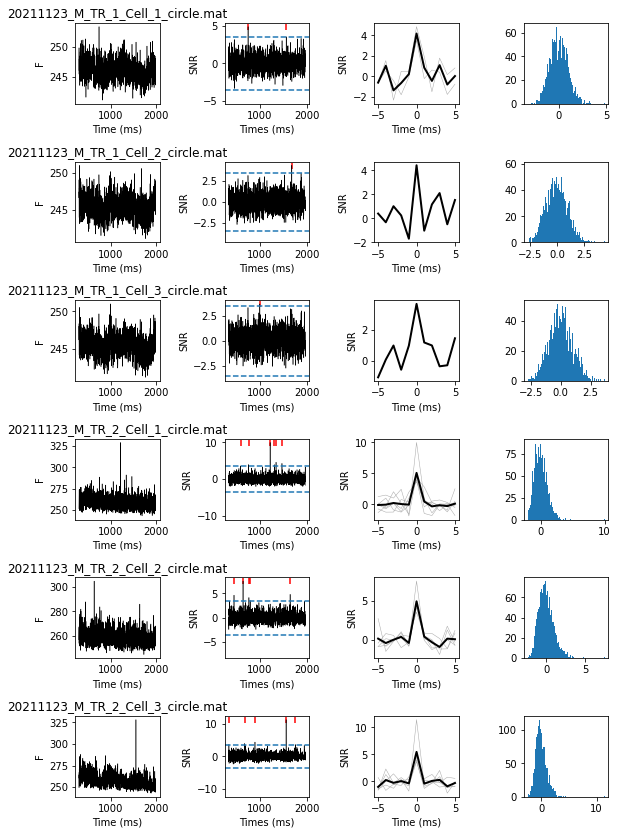

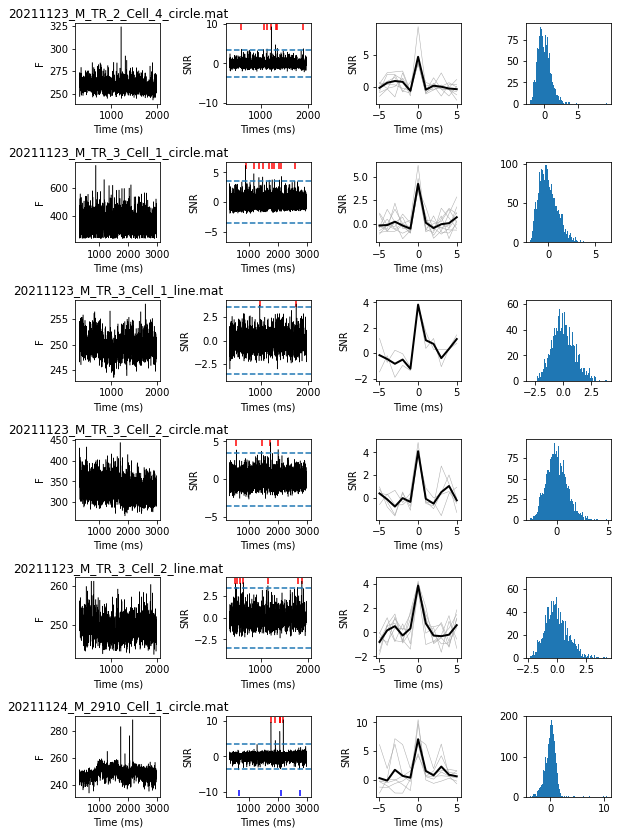

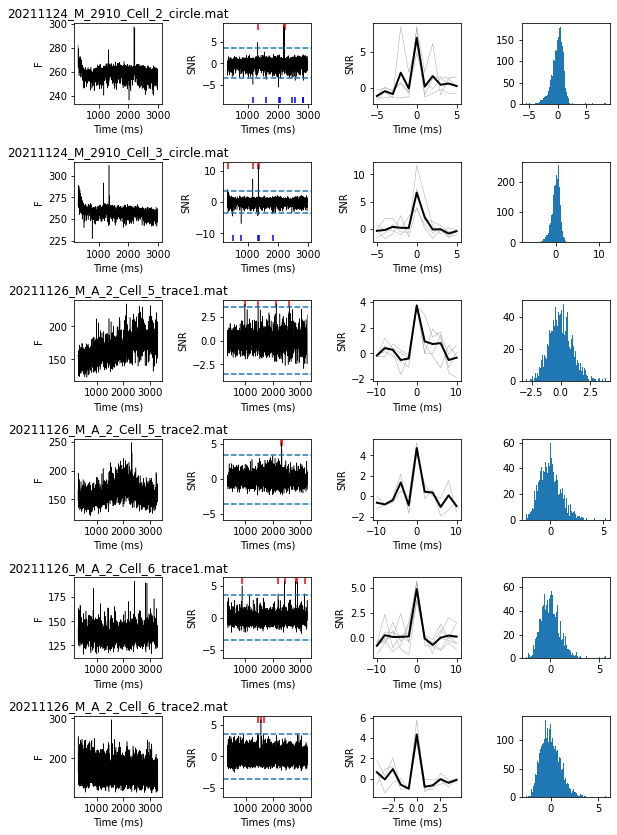

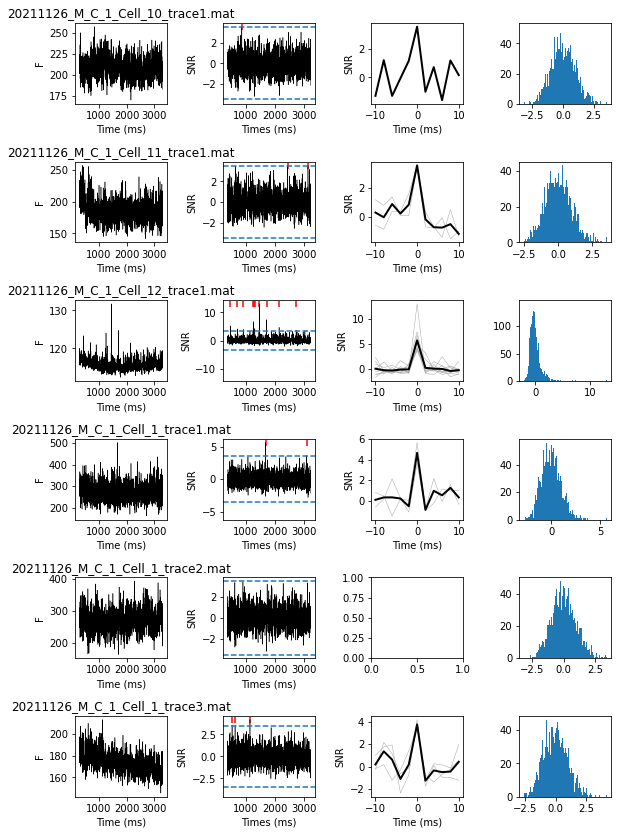

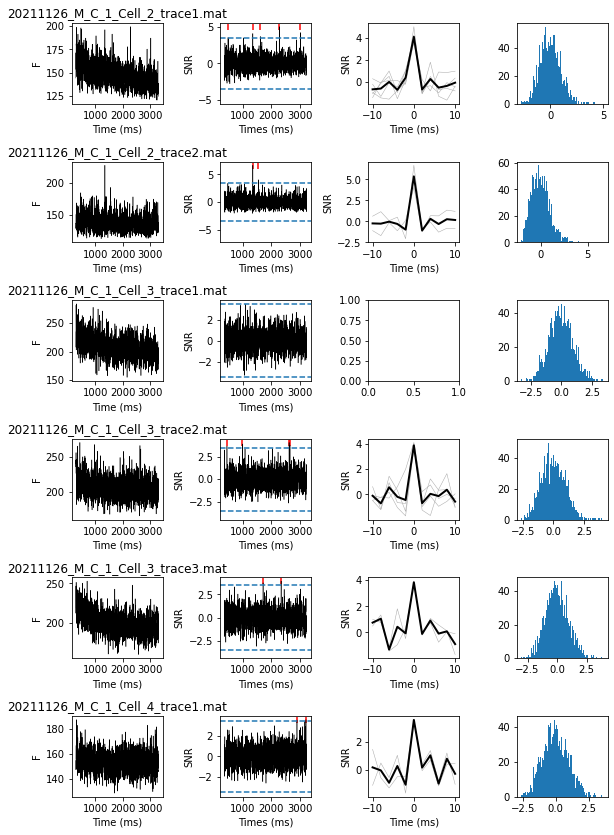

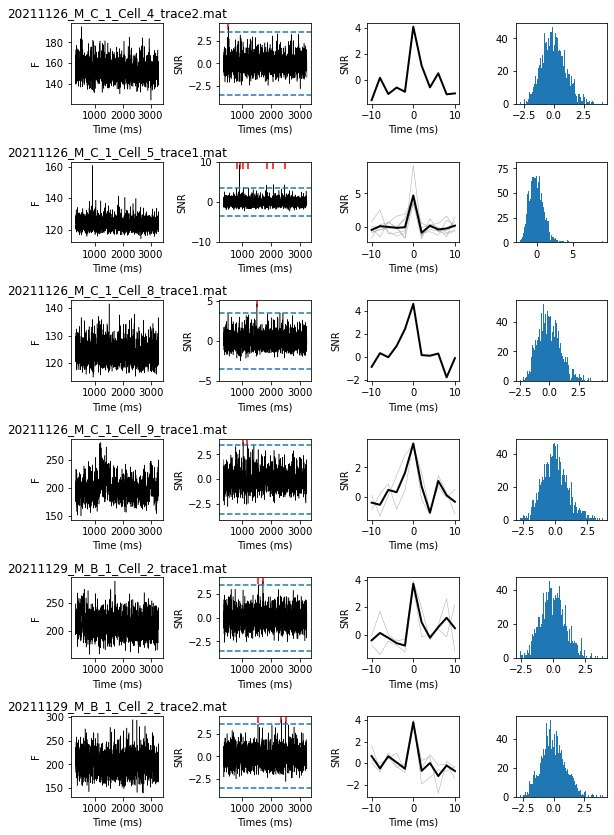

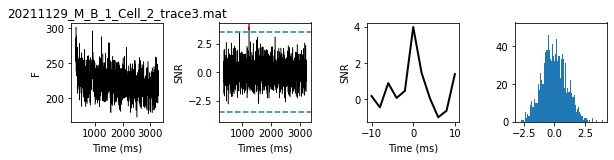

In [15]:
list_not_2_dim = list()
nrow = 6
ncol = 4

fig = plt.figure(figsize = (8.3, 11.7), tight_layout = 3)
cursor_figure = 1

pdf_name = 'neurons_solomiia_bands_SNR_' + str(threshold).replace('.', '-') + '.pdf'

with PdfPages(pdf_name) as pdf:
    for fname, cur_file in dict_data.items():

        data = getDataKymo(cur_file)
        signal = data[1,:]

        if data.shape[0] != 2:
            list_not_2_dim.append(fname)    
            continue

        fs = len(data[0,:])/(data[0,-1] - data[0,0]) #kHz   

        #Raw data
        plt.subplot(nrow, ncol, cursor_figure)
        plt.plot(data[0,:], data[1,:], c = 'k', linewidth = 0.5)
        plt.title(fname)
        plt.xlabel('Time (ms)')
        plt.ylabel('F')
        cursor_figure += 1

        #Zscore
        plt.subplot(nrow, ncol, cursor_figure)
        zscore_val = movingZscore(signal, half_window, True)
        extreme_val = 1.1*np.max([np.max(np.abs(zscore_val)),threshold])
        peaks = peakDetection(zscore_val, threshold)
        peaks_neg = peakDetection(zscore_val, threshold, invert_signal = True)
        time_axis = data[0,half_window:-half_window]
        plt.plot(time_axis, zscore_val, c = 'k', linewidth = 0.5)
        plt.scatter(time_axis[peaks], [0.9*extreme_val]*len(peaks), c = 'r', marker = '|')
        plt.scatter(time_axis[peaks_neg], [-0.9*extreme_val]*len(peaks_neg), c = 'blue', marker = '|')
        plt.ylim(-extreme_val, extreme_val)
        plt.axhline(threshold, linestyle = '--')
        plt.axhline(-threshold, linestyle = '--')            
        plt.xlabel('Times (ms)')
        plt.ylabel('SNR')
        cursor_figure += 1  

        #Spike shape
        plt.subplot(nrow,ncol,cursor_figure)
        if len(peaks) > 0:
            mat_STA = np.zeros(shape = (len(peaks), 2*half_window_STA + 1))
            keep_row = np.ones(len(peaks), dtype = 'bool')
            for i,p in enumerate(peaks):
                vect = zscore_val[p-half_window_STA:p+half_window_STA+1]
                if len(vect) == 2*half_window_STA + 1:
                    mat_STA[i,0:len(vect)] = vect
                else:
                    keep_row[i] = False
            mat_STA = mat_STA[keep_row,:]
            ts = np.linspace(-half_window_STA/fs, half_window_STA/fs, num = mat_STA.shape[1])
            plt.plot(ts,mat_STA.T, c = 'darkgray', linewidth = 0.5)
            plt.plot(ts,np.mean(mat_STA, axis = 0), c = 'black', linewidth = 2)
            plt.xlabel('Time (ms)')
            plt.ylabel('SNR')
        cursor_figure += 1   
        
        #Histogram of zzcored values
        plt.subplot(nrow,ncol,cursor_figure)
        plt.hist(zscore_val,100)
        cursor_figure += 1
        
        if cursor_figure > nrow * ncol:
            pdf.savefig()
            fig = plt.figure(figsize = (8.3, 11.7), tight_layout = 3)
            cursor_figure = 1
            
    pdf.savefig()

## Plots with multiple bands

In [ ]:
hide = True

if not hide:
    for fname in list_not_2_dim:

        cur_file = dict_data[fname]
        spikes_pos = list()
        spikes_neg = list()

        data = getDataKymo(cur_file)   
        if fname in cells_to_crop_end:
            data = data[:,:-20]
        n_plots = data.shape[0] - 1

        cursor_figure = 1
        plt.figure(figsize = (10, 5*n_plots))

        for i,signal in enumerate(data[1:,:]):

            #Plotting raw data
            plt.subplot(n_plots+1, 2, cursor_figure) 
            plt.plot(data[0,:], signal, c = 'k', linewidth = 0.5)
            plt.title(fname)
            cursor_figure += 1

            #Plotting zscored data        
            plt.subplot(n_plots + 1, 2, cursor_figure)
            zscore_val = movingZscore(signal, half_window, False)
            extreme_val = 1.1*np.max(np.abs(zscore_val))
            peaks = peakDetection(zscore_val, threshold)
            peaks_neg = peakDetection(zscore_val, threshold, invert_signal = True)
            time_axis = data[0,half_window:-half_window]
            plt.plot(time_axis, zscore_val, c = 'k', linewidth = 0.5)
            plt.scatter(time_axis[peaks], [0.9*extreme_val]*len(peaks), c = 'r', marker = '|')
            plt.scatter(time_axis[peaks_neg], [-0.9*extreme_val]*len(peaks_neg), c = 'blue', marker = '|')
            plt.xlabel('Time (ms)')
            plt.ylim(-extreme_val, extreme_val)
            plt.axhline(threshold, linestyle = '--')
            plt.axhline(-threshold, linestyle = '--')   
            cursor_figure += 1        
            spikes_pos.append(time_axis[peaks])

        #Plotting the recap for spikes
        plt.subplot(n_plots+1, 2, cursor_figure)
        for (i,v) in enumerate(spikes_pos):
            plt.scatter(v, [i]*len(v))
        plt.ylim(-0.5, len(spikes_pos) - 0.5)        

# Butterworth filters

In [ ]:
filter_order = 4
start_cutoff = 50

nrow = 3
ncol = 3

fig = plt.figure(figsize = (15.7, 8.3), tight_layout = 0)
cursor_figure = 1

pdf_name = 'butterworth_filtering_higher_freq_allstd_' + str(filter_order) + '.pdf'
filter_frequencies = [50,100]

with PdfPages(pdf_name) as pdf:
    for fname, cur_file in dict_data.items():

        data = getDataKymo(cur_file)
        signal = data[1,:]

        if data.shape[0] != 2:
            continue

        fs = len(data[0,:])/(data[0,-1] - data[0,0]) #kHz   

        #Zscore
        plt.subplot(nrow, ncol, cursor_figure)
        zscore_val = movingZscore(signal, half_window, True)
        extreme_val = 1.1*np.max([np.max(np.abs(zscore_val)),threshold])
        peaks = peakDetection(zscore_val, threshold)
        peaks_neg = peakDetection(zscore_val, threshold, invert_signal = True)
        time_axis = data[0,half_window:-half_window]
        plt.plot(time_axis, zscore_val, c = 'k', linewidth = 0.5)
        plt.scatter(time_axis[peaks], [0.9*extreme_val]*len(peaks), c = 'r', marker = '|')
        plt.scatter(time_axis[peaks_neg], [-0.9*extreme_val]*len(peaks_neg), c = 'blue', marker = '|')
        plt.xlabel('Time (ms)')
        plt.ylim(-extreme_val, extreme_val)
        plt.axhline(threshold, linestyle = '--')
        plt.axhline(-threshold, linestyle = '--')            
        plt.xlabel('Times (ms)')
        plt.ylabel('SNR')
        cursor_figure += 1  

        for freq in filter_frequencies:
            plt.subplot(nrow, ncol, cursor_figure)
            sos = butter(filter_order, freq, 'low', fs = fs*1e3, output='sos')
            filtered = sosfilt(sos, signal)
            filtered = filtered[start_cutoff:]
            zscore_filtered = movingZscore(filtered, half_window, True)
            plt.plot(data[0,half_window+start_cutoff:-half_window], zscore_filtered, linewidth = 0.5, c = 'k')
            plt.title(str(freq) + ' Hz')
            cursor_figure += 1            
            
        if cursor_figure > nrow * ncol:
            pdf.savefig()
            fig = plt.figure(figsize = (15.7, 8.3), tight_layout = 0)
            cursor_figure = 1
            
    pdf.savefig()

In [ ]:

# butter(filter_order, filter_frequencies[0], 